# Credit Card Analytics 💳

Last tested version: <img src="https://img.shields.io/badge/Atoti-v0.8.14-blue">

Welcome to our credit card analytics notebook! Here we'll be using Atoti to analyze `5` million records worth of credit card sales transactions, joined together with a rich data model of users, loans, and retailer attributes. Let's see what insights we can generate!

**💡 Note:** Our credit card datasets come from [Kaggle](https://www.kaggle.com/datasets/ealtman2019/credit-card-transactions/data), feel free to check it out!

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=credit-card-analytics" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="Try atoti"></a></div>

## 1. Import Libraries

First things first, let's import our libraries.

In [1]:
import atoti as tt
import pandas as pd
import time
from pprint import pprint

# Set max rows and columns for DataFrame
pd.options.display.max_rows = 10000
pd.options.display.max_columns = 10000

## 2. Instantiate Atoti Server and Link UI

Next, we'll spin up the Atoti server and link the session to our web-based Atoti UI.

💡 **Note**: https://docs.atoti.io/latest/api/atoti.Session.html#atoti.Session

In [2]:
# Create a Session with corresponding parameters set
session = tt.Session(
    user_content_storage="./content",
    port=9092,
    java_options=["-Xms1G", "-Xmx10G"],
)
session.link

http://localhost:9092

_Note_: This is the session's local URL: it may not be reachable if Atoti is running on another machine.

## 3. Load CSVs from S3 Into Atoti Tables 

Now let's load our CSVs from S3 into their respective Atoti Tables.

* [Transactions](#Transactions)
* [Credit Cards](#Credit-Cards)
* [Users](#Users)
* [Retailers](#Retailers)
* [Loans](#Loans)

We can use the `read_csv` function to create our Atoti tables and subsequently load them with data. In addition, we can explicitly define our column data types as well as account for Datetime data types using the `types` and `date_patterns` parameters, respectively. All other columns and their data types for the loaded dataset are automatically inferred via the `read_csv` function.

💡 **Note:** We should be mindful of numerical columns that we intend to use as hierarchies instead of measures (e.g. a User ID does not need to be aggregated). For this reason, we explicitly set Atoti table columns as desired data types when using the [read_csv()](https://docs.atoti.io/latest/api/atoti.Session.read_csv.html#atoti.Session.read_csv) function to load data into Atoti tables.

### Transactions

In [3]:
transactions_table = session.read_csv(
    "s3://data.atoti.io/notebooks/retail-banking/data/credit_card_transactions_processed_5MM.csv.gz",
    types={
        "Datetime": tt.type.LOCAL_DATE_TIME,
        "User": tt.type.STRING,
        "Card": tt.type.STRING,
        "Merchant Name": tt.type.STRING,
        "Zip": tt.type.STRING,
        "MCC": tt.type.STRING,
    },
    date_patterns={"Datetime": "yyyy-MM-dd HH:mm:ss"},
    table_name="Transactions",
)
transactions_table.head()

,User,Card,Datetime,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,1158,1,2013-05-29 21:08:00,-12.6,Swipe Transaction,Merchant 57154,Aurora,CO,80013.0,5812,N/A,No
1,50,0,2019-07-04 23:37:00,4.432,Chip Transaction,Merchant 47076,Beaverton,OR,97007.0,5921,N/A,No
2,1158,2,2014-07-20 20:58:00,-12.412,Swipe Transaction,Merchant 57154,Aurora,CO,80013.0,5812,N/A,No
3,1765,0,2014-09-09 02:54:00,1.712,Swipe Transaction,Merchant 13083,Chilton,WI,53014.0,5921,N/A,No
4,1397,1,2006-12-06 19:15:00,9.852,Swipe Transaction,Merchant 57154,Aurora,CO,80013.0,5812,N/A,No


### Credit Cards

In [4]:
credit_cards_table = session.read_csv(
    "s3://data.atoti.io/notebooks/retail-banking/data/cards_processed.csv",
    types={
        "User": tt.type.STRING,
        "Card": tt.type.STRING,
        "Retailer ID": tt.type.STRING,
        "Card Number": tt.type.STRING,
        "CVV": tt.type.STRING,
        "Acct Open Date": tt.type.LOCAL_DATE,
    },
    date_patterns={"Acct Open Date": "yyyy-MM-dd"},
    table_name="Credit Cards",
)
credit_cards_table.head()

,User,Card,Retailer ID,Card Number,Expires,CVV,Has Chip,Cards Issued,Credit Limit,Acct Open Date,Year PIN last Changed,Card on Dark Web
0,319,0,11,5023863713584517,12/2024,457,YES,2,60400,2010-11-01,2013,No
1,319,2,13,5486901761554156,10/2023,258,YES,2,55269,2003-01-01,2016,No
2,5,0,20,4099623033306950,09/2021,74,YES,2,59900,2002-01-01,2019,No
3,8,1,12,5668831527649353,01/2021,356,YES,1,73253,2017-09-01,2017,No
4,321,3,13,5916860407845357,10/2024,827,YES,2,64983,2006-11-01,2010,No


### Users

In [5]:
users_table = session.read_csv(
    "s3://data.atoti.io/notebooks/retail-banking/data/users_processed.csv",
    types={
        "User": tt.type.STRING,
        "Birth Month": tt.type.STRING,
        "Zipcode": tt.type.STRING,
        "FICO Score": tt.type.STRING,
        "Current Age": tt.type.STRING,
        "Age Range": tt.type.STRING,
        "Retirement Age": tt.type.STRING,
    },
    table_name="Users",
)
users_table.head()

,User,Person,Current Age,Retirement Age,Birth Year,Birth Month,Gender,Address,Apartment,City,State,Zipcode,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards,EAD,PD12,PDLT,LGD,Age Range,Income Range
0,0,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,<NA>,La Verne,CA,91750,34.15,-117.76,29278,59696,127613,787,5,7543.452009,0.102502,0.148166,0.608904,50-59,50K - 80K
1,838,Apollo Roberts,52,68,1968,2,Male,531 Pine Avenue,<NA>,Eaton,IN,47338,40.34,-85.35,15048,30681,81680,746,4,8266.636203,0.128678,0.176423,0.614041,50-59,20K - 50K
2,214,Eva Roman,28,59,1991,12,Female,7087 Plum Street,<NA>,Saint Petersburg,FL,33706,27.75,-82.64,26476,53984,76118,701,1,8943.9972,0.105292,0.150311,0.602701,20-29,50K - 80K
3,908,Kylan Murphy,45,61,1975,1,Male,2270 Sixth Lane,10.0,Humble,TX,77346,29.99,-95.26,32943,67170,114251,489,3,9408.783007,0.097141,0.147744,0.606864,40-49,50K - 80K
4,1278,Briggs Campbell,66,61,1953,7,Male,338 Littlewood Street,88.0,Lawrenceville,GA,30043,33.94,-83.99,24252,57383,20725,799,4,9094.913965,0.103074,0.154528,0.605476,60+,50K - 80K


### Retailers

In [6]:
retailers_table = session.read_csv(
    "s3://data.atoti.io/notebooks/retail-banking/data/retailers.csv",
    types={
        "Retailer ID": tt.type.STRING,
    },
    table_name="Retailers",
)
retailers_table.head()

,Retailer ID,Retailer Name,Card Brand,Card Type,Level 1,Level 2,Level 3,Level 4,Level 5,Industry
0,1,Cathay Pacific Elite,Amex,Credit,Bank Corp,Consumer Banking,Cards Business,Travel,Airline,Airline
1,2,Hilton Honors,Amex,Credit,Bank Corp,Consumer Banking,Cards Business,Travel,Hotel,Hotel
2,9,Banana Republic,Mastercard,Credit,Bank Corp,Consumer Banking,Cards Business,Retail,Consumer Discretionary,Fashion
3,12,Venmo,Mastercard,Debit,Bank Corp,Consumer Banking,Cards Business,Financials,Cards & Banking,Cards & Banking
4,28,Chase,Visa,Debit,Bank Corp,Consumer Banking,Cards Business,Financials,Cards & Banking,Cards & Banking


### FICO

In [7]:
fico_table = session.read_csv(
    "s3://data.atoti.io/notebooks/retail-banking/data/fico.csv",
    table_name="FICO",
    types={"FICO Score": tt.type.STRING},
)
fico_table.head()

,FICO Score,FICO Level,FICO Range
0,300,Poor,300-579
1,328,Poor,300-579
2,331,Poor,300-579
3,349,Poor,300-579
4,350,Poor,300-579


### Loans Table

In [8]:
user_loans_table = session.read_csv(
    "s3://data.atoti.io/notebooks/retail-banking/data/loans.csv",
    types={
        "User": tt.type.STRING,
        "Inq Last 6mos": tt.type.STRING,
        "Delinq 2yrs": tt.type.STRING,
        "Public Record": tt.type.STRING,
        "Not Fully Paid": tt.type.STRING,
    },
    table_name="Loans",
)
user_loans_table.head()

,User,Credit Policty,Loan Purpose,Interest Rate,Installment,DTI,Days with Credit Line,Revolving Bal,Revol_Util,Inq Last 6mos,Delinq 2yrs,Public Record,Not Fully Paid
0,1905,0,Debt Consolidation,0.1786,72.17,28.73,4709.0,6076,79.9,6,1,0,0
1,957,1,Debt Consolidation,0.1695,712.54,13.61,4830.041667,16473,94.1,2,2,0,0
2,960,1,All Other,0.1316,101.32,14.08,3810.041667,2490,49.8,1,1,0,0
3,4,0,Debt Consolidation,0.1671,710.18,20.83,3269.0,11881,50.8,4,0,0,1
4,1910,0,Major Purchase,0.1501,346.73,7.75,1500.0,16246,83.3,1,0,0,1


## 4. Join Tables and Create Cube

Now, that our data is loaded into our Atoti Tables and in the format that we want, we should join our tables together on common keys to extend attributes from other entity relationships, and create our Atoti cube.

In [9]:
# Join tables
transactions_table.join(
    credit_cards_table,
    (transactions_table["User"] == credit_cards_table["User"])
    & (transactions_table["Card"] == credit_cards_table["Card"]),
)
transactions_table.join(users_table, transactions_table["User"] == users_table["User"])
users_table.join(fico_table, users_table["FICO Score"] == fico_table["FICO Score"])
credit_cards_table.join(
    retailers_table, credit_cards_table["Retailer ID"] == retailers_table["Retailer ID"]
)
users_table.join(user_loans_table, users_table["User"] == user_loans_table["User"])

In [10]:
# Create Cube from Atoti Table object
cube = session.create_cube(transactions_table)

## 5. Analyze the Atoti Cube

Now that the data has been loaded into the cube, we'll want to examine the data model of the cube to confirm that the columns and data types match up to what we expect. In addition, we can view the hierarchies, levels, and measures for our cube by assigning them to variables.

💡 **Note:** https://docs.atoti.io/latest/getting_started/tutorial/tutorial.html#Multidimensional-concepts

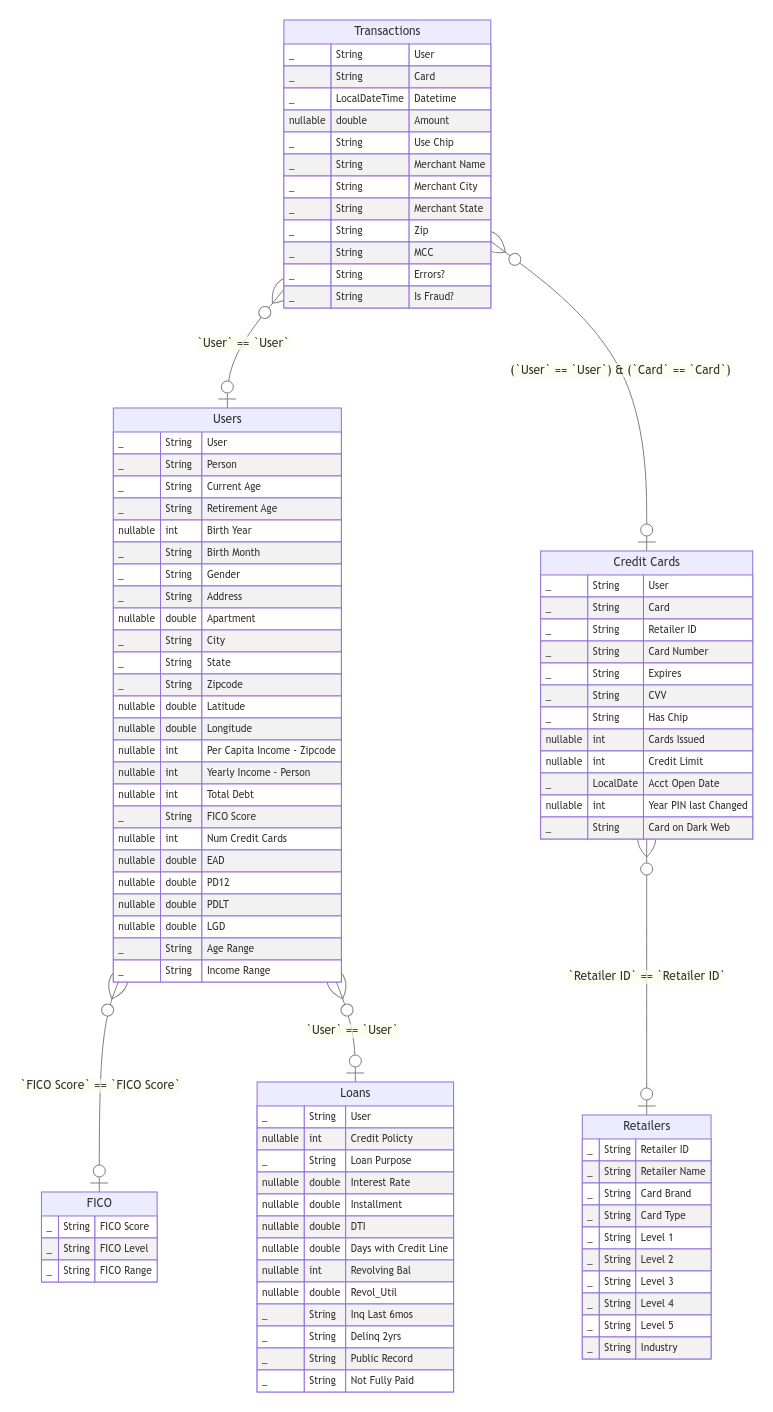

In [11]:
# View the schema of the data model
session.tables.schema

In [12]:
# Set variables for hierarchies, levels, and measures
h, l, m = cube.hierarchies, cube.levels, cube.measures

## 6. Enrich the Atoti Cube

Based on our analysis, there are a few aspects that we can do to enrich our cube, namely creating multi-level hierarchies, adjusting the ordering for particlar levels, and creating new measures.

* [Create Multi-Level Hierarchies](#Create-Multi-Level-Hierarchies)
* [Adjust Level Ordering](#Adjust-Level-Ordering)
* [Create New Measures](#Create-New-Measures)
* [Validate Measures](#Validate-Measures)
* [Create Credit Risk Measures](#Create-Credit-Risk-Measures)

### Create Multi-Level Hierarchies

Here we'll create a multi-level date hierarchy that allows us to break down our `Datetime` column into multiple levels. This allows us to drill-down from the top-level (in this case `Year`) to each underlying level, and see the breakdown of how each underlying level contributes to the overall measure aggregation. In addition, this also gives us more granularity in how we aggregate our measures, as we can specify the `OriginScope` which defines the level at which we perform our aggregations when creating new measures.

💡 **Note:** 

* https://docs.atoti.io/latest/api/atoti.Cube.create_date_hierarchy.html#atoti.Cube.create_date_hierarchy
* https://docs.atoti.io/latest/api/atoti.OriginScope.html#atoti.OriginScope

In [13]:
# Create a multi-level date hierarchy and clean up corresponding single-level hierarchy
cube.create_date_hierarchy(
    "Transaction Date",
    column=transactions_table["Datetime"],
    levels={
        "Year": "yyyy",
        "Quarter": "QQQ",
        "Month": "MMM",
        "Day": "dd",
        "Hour": "HH",
    },
)
# cube.create_date_hierarchy(
#     "Acct Open Date",
#     column=credit_cards_table["Acct Open Date"],
#     levels={
#         "Year": "yyyy",
#         "Quarter": "QQQ",
#         "Month": "MMM",
#     },
# )

del h["Datetime"]

# Create multi-level hierarchy and clean up corresponding single-level hierarchies
h["Retailer Levels"] = [
    l["Level 1"],
    l["Level 2"],
    l["Level 3"],
    l["Level 4"],
    l["Level 5"],
]
del h["Level 1"]
del h["Level 2"]
del h["Level 3"]
del h["Level 4"]
del h["Level 5"]

### Adjust Level Ordering

In addition, we can use `CustomOrder` to customize the order of values for a specified level.

💡 **Note:** https://docs.atoti.io/latest/api/atoti.CustomOrder.html#atoti.CustomOrder

In [14]:
# Set Income Range level ordering as a user-defined CustomOrder
l["Income Range"].order = tt.CustomOrder(
    first_elements=[
        "0K - 20K",
        "20K - 50K",
        "50K - 80K",
        "80K - 100K",
        "100K - 150K",
        "150K - 200K",
        "200K+",
    ]
)

# Set FICO level ordering as a user-defined CustomOrder
l["FICO Level"].order = tt.CustomOrder(
    first_elements=["Poor", "Fair", "Good", "Very Good", "Exceptional"]
)

### Create New Measures

Now, let's create some new measures! For this part, we'll be creating measures relating to user credit (credit cards) and debt (loans). Overall, we'll be showcasing a number of different aggregate functions, so feel free to check out the associated documentation as needed.

💡 **Note:** 

* https://docs.atoti.io/latest/api/atoti.agg.count_distinct.html#atoti.agg.count_distinct
* https://docs.atoti.io/latest/api/atoti.agg.single_value.html#atoti.agg.single_value
* https://docs.atoti.io/latest/api/atoti.agg.sum.html#atoti.agg.sum
* https://docs.atoti.io/latest/api/atoti.OriginScope.html#atoti.OriginScope



In [15]:
# # Create count distinct measure
# m["Num Credit Cards"] = tt.agg.count_distinct(credit_cards_table["Card Number"])

# # Create single value measures
# m["Income Annual"] = tt.agg.single_value(users_table["Yearly Income - Person"])
# m["Interest Rate"] = tt.agg.single_value(user_loans_table["Interest Rate"])
# m["Days with Credit Line"] = tt.agg.single_value(
#     user_loans_table["Days with Credit Line"]
# )
# m["Total Debt.SV"] = tt.agg.single_value(users_table["Total Debt"])
# m["Credit_Limit.SV"] = tt.agg.single_value(credit_cards_table["Credit Limit"])
# m["Revolving Balance.SV"] = tt.agg.single_value(user_loans_table["Revolving Bal"])
# m["Revolving Utilization.SV"] = tt.agg.single_value(user_loans_table["Revol_Util"])

# # Create measures and define aggregation scope (as needed)
# m["Card Debt"] = tt.agg.sum(transactions_table["Amount"])
# m["Total Debt"] = tt.agg.sum(
#     m["Total Debt.SV"],
#     scope=tt.OriginScope(levels={l[("Transactions", "User", "User")]}),
# )
# m["Credit Limit"] = tt.agg.sum(
#     m["Credit_Limit.SV"], scope=tt.OriginScope(levels={l["Card Number"]})
# )
# m["Revolving Balance"] = tt.agg.sum(
#     m["Revolving Balance.SV"],
#     scope=tt.OriginScope(levels={l["User"]}),
# )
# m["Revolving Utilization"] = tt.agg.sum(
#     m["Revolving Utilization.SV"],
#     scope=tt.OriginScope(levels={l[("Transactions", "User", "User")]}),
# )

# # Create measures from other calculated measures
# m["Utilization"] = m["Card Debt"] / m["Credit Limit"]
# m["Utilization"].formatter = "DOUBLE[0.00%]"

In [16]:
# Card Debt, User Debt, Loan Debt
m["Card Debt"] = tt.agg.sum(transactions_table["Amount"])
m["User Debt"] = tt.agg.single_value(users_table["Total Debt"])

# Card Details
m["Num Credit Cards"] = tt.agg.count_distinct(credit_cards_table["Card Number"])
m["Credit Limit"] = tt.agg.single_value(credit_cards_table["Credit Limit"])
m["Credit Card Utilization"] = tt.agg.mean(
    m["Card Debt"] / m["Credit Limit"],
    scope=tt.OriginScope(levels={l[("Credit Cards", "Card Number", "Card Number")]}),
)

# Risk Metrics


# m["Total Debt"] = tt.agg.sum((m['Card Debt'] + m['User Debt.SV']), scope=tt.OriginScope(levels={l[("Transactions", "User", "User")]}))

### Validate Measures

We can then take a look at our newly created measures to validate that they are indeed working properly. Take a look at the underlying values to validate the measure calculations/aggregations.

In [17]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.

### Create Credit Risk Measures


Lastly, we'll create new credit risk measures and calculate the expected credit loss for each user.

$$ ECL = EAD * PD * LGD $$

Where...
* ECL = Expected credit losses
* EAD = Exposure at default
* PD = Probability of default
* LGD = Loss given default

💡 **Note:** 

* https://docs.atoti.io/latest/api/atoti.agg.mean.html#atoti.agg.mean
* https://docs.atoti.io/latest/api/atoti.agg.sum_product.html#atoti.agg.sum_product

In [18]:
# Create new credit risk measures
# m["PD12"] = tt.agg.mean(
#     tt.agg.single_value(users_table["PD12"]),
#     scope=tt.OriginScope(levels={l[("Transactions", "User", "User")]}),
# )
# m["PDLT"] = tt.agg.mean(
#     tt.agg.single_value(users_table["PDLT"]),
#     scope=tt.OriginScope(levels={l[("Transactions", "User", "User")]}),
# )
# m["LGD"] = tt.agg.mean(
#     tt.agg.single_value(users_table["LGD"]),
#     scope=tt.OriginScope(levels={l[("Transactions", "User", "User")]}),
# )
# m["EAD"] = m["Card Debt"]
# m["ECL"] = tt.agg.sum_product(
#     m["Card Debt"],
#     m["LGD"],
#     m["PD12"],
#     scope=tt.OriginScope(levels={l[("Transactions", "User", "User")]}),
# )

# # Format our measures as percentages
# m["PD12"].formatter = "DOUBLE[0.00%]"
# m["PDLT"].formatter = "DOUBLE[0.00%]"
# m["LGD"].formatter = "DOUBLE[0.00%]"

# # Categorize our measures
# m["PD12"].folder = "Credit Risk"
# m["PDLT"].folder = "Credit Risk"
# m["LGD"].folder = "Credit Risk"
# m["EAD"].folder = "Credit Risk"
# m["ECL"].folder = "Credit Risk"

## 7. View Dashboards

With our cube fully set up and ready-to-go, let's now create our visualizations via slicing-and-dicing. We'll create dashboards for the following categories:

* [Overview](#Overview-Dashboard)
* [Customers](#Customers-Dashboard)
* [Retailers](#Retailers-Dashboard)
* [Transactions](#Transactions-Dashboard)

### Overview Dashboard

View overall credit risk, distribution of loan types, credit card exposure, etc.

In [19]:
# Use `session.link` to link to Overview Dashboard
session.link / "#/dashboard/935"

http://localhost:9092/#/dashboard/935

_Note_: This is the session's local URL: it may not be reachable if Atoti is running on another machine.

### Customers Dashboard

View customer credit risk, loan types, credit card exposure, etc. 

In [20]:
# Use `session.link` to link to Customers Dashboard
session.link / "#/dashboard/38c"

http://localhost:9092/#/dashboard/38c

_Note_: This is the session's local URL: it may not be reachable if Atoti is running on another machine.

### Retailers Dashboard

View retailer exposure by industry.

In [21]:
# Use `session.link` to link to Retailers Dashboard
session.link / "#/dashboard/3c2"

http://localhost:9092/#/dashboard/3c2

_Note_: This is the session's local URL: it may not be reachable if Atoti is running on another machine.

### Transactions Dashboard

View transactions by customer name, retailers, transaction year, or transaction city.

In [22]:
# Use `session.link` to link to Transactions Dashboard
session.link / "#/dashboard/85d"

http://localhost:9092/#/dashboard/85d

_Note_: This is the session's local URL: it may not be reachable if Atoti is running on another machine.

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=credit-card-analytics" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Try atoti"></a></div>